# Pathway activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering pathway activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for pathway activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the **Usage** tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

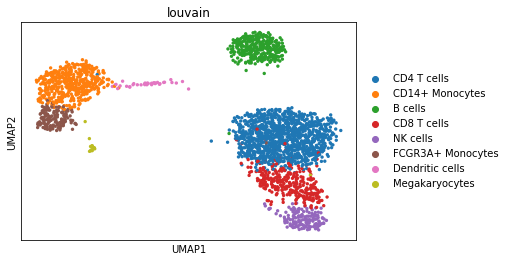

In [3]:
sc.pl.umap(adata, color='louvain')

## PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (mouse is also available) and we will use the top 500 responsive genes ranked by p-value. To access it we can use `decoupler`.

In [4]:
model = dc.get_progeny(organism='human', top=500)
model

,source,target,weight,p_value
0,PI3K,GOLT1B,2.485035,0.000100
1,Androgen,GTF2E1,-2.128934,0.000100
2,MAPK,TMEM67,-0.626463,0.000100
3,VEGF,RER1,0.967865,0.000100
4,PI3K,CCNJ,1.963863,0.000100
...,...,...,...,...
6995,Trail,GRIN3A,0.653140,0.114436
6996,Trail,STRC,-0.635035,0.114489
6997,Trail,TLN1,0.877321,0.114594
6998,Trail,NFKBIA,4.454585,0.114629


## Activity inference with Multivariate Linear Model

To infer activities we will run the Multivariate Linear Model method (`mlm`). It models the observed gene expression by using a regulatory adjacency matrix (target genes x pathways) as covariates of the linear model. The values of this matrix are the associated interaction weights.
The obtained t-values of the fitted model are the activity scores.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [5]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

58 features of mat are empty in 2635 samples, they will be ignored.
Running mlm on mat with 2638 samples and 13656 targets for 14 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [6]:
adata.obsm['mlm_estimate']

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACATACAACCAC-1,1.320825,-0.764068,-1.961235,1.668189,0.468899,2.032308,-2.157487,0.622527,-0.769605,-0.323122,0.109460,-0.404623,1.910240,1.139018
AAACATTGAGCTAC-1,2.127944,-0.786134,-1.626606,2.060642,3.088329,-0.640427,-0.457510,1.226427,-1.478549,0.406885,0.771072,-0.354107,1.019975,0.182020
AAACATTGATCAGC-1,0.299178,0.452016,0.692895,1.601688,0.831817,2.629045,-1.658921,0.342096,-1.707228,1.620205,-0.325378,-1.265313,0.456827,1.292804
AAACCGTGCTTCCG-1,2.931521,0.506896,-0.746980,2.231913,3.898636,0.023183,0.030635,-0.882563,-0.895277,2.588279,1.472669,-1.359813,1.735206,1.471001
AAACCGTGTATGCG-1,1.446363,-0.334798,-1.045569,0.169056,1.938552,2.534057,-0.979505,0.838613,0.428515,2.019955,0.219454,-0.678030,0.204982,1.055981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1.848491,0.914132,-2.215294,2.059708,3.591647,0.493261,-0.024073,-1.180956,-0.859404,3.468144,0.683186,-1.300303,1.266462,1.985656
TTTCTACTGAGGCA-1,0.685169,-0.562286,-0.873414,1.123129,3.364195,2.354791,-2.206087,1.007551,-1.034994,1.227000,-2.178228,0.434862,1.227260,1.095492
TTTCTACTTCCTCG-1,1.373956,-0.610181,-1.928856,3.133175,2.280336,1.506574,-0.826584,-0.979757,-0.236049,-0.015968,2.750654,-0.589052,0.835075,0.209889
TTTGCATGAGAGGC-1,0.750623,-0.821639,0.192621,1.618518,3.032389,1.634114,-0.117148,-1.339318,-0.315678,1.080598,0.866871,0.119501,1.660611,0.490342


## Visualization

To visualize the obtianed scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract the activities from the `adata` object.

In [7]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 14
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

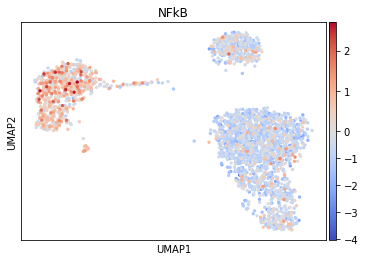

In [8]:
sc.pl.umap(acts, color='NFkB', vcenter=0, cmap='coolwarm')

## Exploration

With `decoupler` we can also see what is the mean activity per group:

In [9]:
mean_acts = dc.summarize_acts(acts, groupby='louvain', min_val=0)
mean_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cells,1.400538,-0.362907,-0.791360,1.577857,2.303224,1.030108,-0.687920,-0.680096,-0.810805,0.141528,1.054281,-0.325393,1.196694,0.543352
CD14+ Monocytes,1.995623,0.148955,-1.811897,1.604716,2.545187,0.863010,0.217368,-0.576775,-0.886336,1.806848,1.214106,-1.226805,1.517377,1.427949
CD4 T cells,1.078525,-0.229111,-0.895369,1.271621,0.887684,1.363142,-0.974130,-0.626049,-0.889340,0.321080,0.003334,-0.274719,1.039862,0.718740
CD8 T cells,1.418123,-0.198049,-0.771840,0.997847,1.422503,1.695879,-0.857882,-0.328844,-0.713816,0.528435,0.153500,-0.218220,1.012099,0.763603
Dendritic cells,2.046336,0.272101,-1.639876,0.930221,3.291136,1.368515,-0.193410,-0.052741,-0.997086,1.650318,0.552460,-1.017986,1.667224,1.386131
FCGR3A+ Monocytes,2.351897,0.300345,-2.003846,2.035052,3.296934,0.738466,0.229510,-0.138862,-1.241204,2.089363,0.722204,-0.829736,1.244162,1.406684
Megakaryocytes,2.832332,0.936388,-1.451876,0.995489,1.283313,2.682966,0.506540,0.238303,-0.734094,0.810067,0.925046,-0.093438,0.612910,1.892730
NK cells,1.440456,-0.451037,-0.819622,0.542671,2.135658,1.870906,-0.646670,0.065764,-0.645315,0.670560,0.307065,-0.410167,0.992072,1.115608


We can visualize which group is more active using `seaborn`:

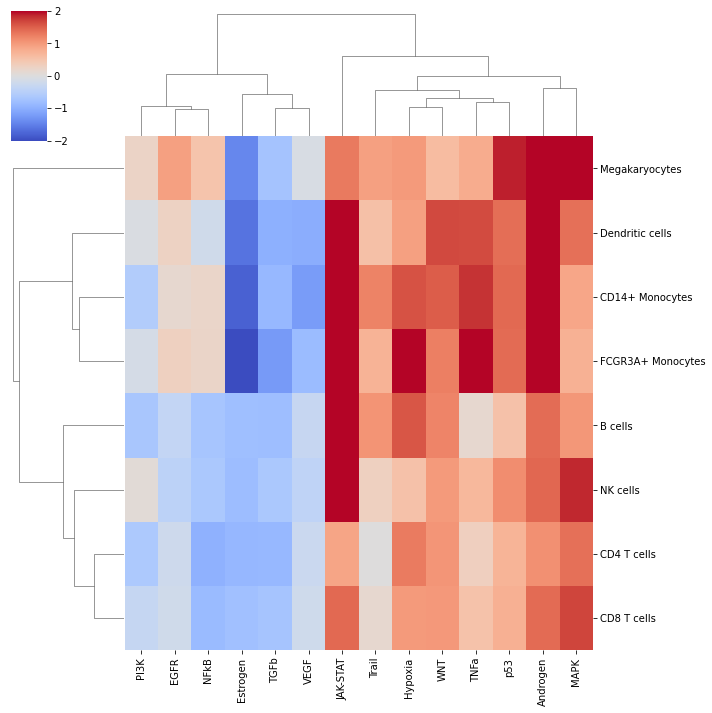

In [10]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, vmin=-2, vmax=2, cmap='coolwarm')
plt.show()

In this specific example, we can observe that NFkB and EGFR seems to be more active in Mieloid cells (excluding B cells)